In [1]:
!wget https://raw.githubusercontent.com/karencfisher/learning-pytorch/main/model_harness.py
!wget https://raw.githubusercontent.com/karencfisher/learning-pytorch/main/utils.py

--2023-03-04 01:20:39--  https://raw.githubusercontent.com/karencfisher/learning-pytorch/main/model_harness.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4586 (4.5K) [text/plain]
Saving to: ‘model_harness.py’

model_harness.py    100%[===================>]   4.48K  --.-KB/s    in 0s      

2023-03-04 01:20:39 (65.7 MB/s) - ‘model_harness.py’ saved [4586/4586]

--2023-03-04 01:20:39--  https://raw.githubusercontent.com/karencfisher/learning-pytorch/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2254 (2.2K) [text

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torchvision
import torchvision.transforms as transforms

from model_harness import ModelHarness
import utils

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

# Create datasets for training & validation, download if necessary
training_set = torchvision.datasets.FashionMNIST('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.FashionMNIST('./data', train=False, transform=transform, download=True)

# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=32, shuffle=True, num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=2)

# Class labels
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Training set has 60000 instances
Validation set has 10000 instances


In [4]:
import torch.nn as nn
import torch.nn.functional as F

# PyTorch models inherit from torch.nn.Module
class GarmentClassifier(nn.Module):
    def __init__(self):
        super(GarmentClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = GarmentClassifier()
model

GarmentClassifier(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [5]:
trainer = ModelHarness(model,
                       torch.nn.CrossEntropyLoss(),
                       torch.optim.Adam,
                       learning_rate = 0.001)

Device = cuda


In [6]:
hist = trainer.train(training_loader, 15)

Epoch 1
1875/1875[====================] 23.2061 sec - Loss: 0.5611 - Accuracy: 79.01%
Epoch 2
1875/1875[====================] 22.9584 sec - Loss: 0.3667 - Accuracy: 86.53%
Epoch 3
1875/1875[====================] 22.7188 sec - Loss: 0.3184 - Accuracy: 88.23%
Epoch 4
1875/1875[====================] 23.1150 sec - Loss: 0.2887 - Accuracy: 89.42%
Epoch 5
1875/1875[====================] 23.5477 sec - Loss: 0.2674 - Accuracy: 90.21%
Epoch 6
1875/1875[====================] 21.5518 sec - Loss: 0.2498 - Accuracy: 90.71%
Epoch 7
1875/1875[====================] 22.5375 sec - Loss: 0.2367 - Accuracy: 91.28%
Epoch 8
1875/1875[====================] 22.4101 sec - Loss: 0.2235 - Accuracy: 91.68%
Epoch 9
1875/1875[====================] 22.4078 sec - Loss: 0.2121 - Accuracy: 92.18%
Epoch 10
1875/1875[====================] 21.6343 sec - Loss: 0.2033 - Accuracy: 92.32%
Epoch 11
1875/1875[====================] 22.5176 sec - Loss: 0.1916 - Accuracy: 92.81%
Epoch 12
1875/1875[====================] 23.4385 sec

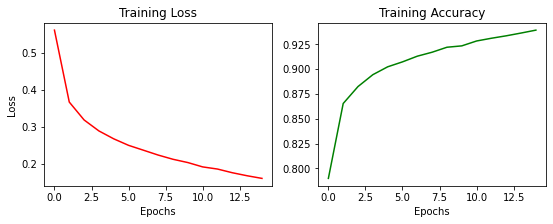

In [7]:
utils.plot_history(hist)

In [8]:
preds, labels, score = trainer.evaluate(validation_loader)

313/313[====================] 3.7489 sec - Accuracy 89.70%


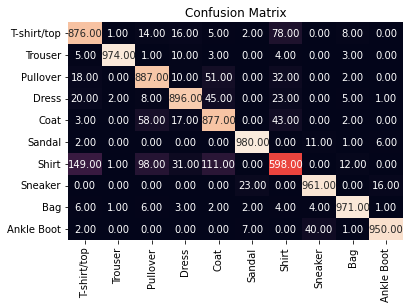

In [16]:
y = [labels.numpy() for _, labels in validation_loader]
y = np.concatenate(y)

cm = confusion_matrix(y, labels)
sns.heatmap(cm,
            annot=True,
            fmt='.2f',
            cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.title('Confusion Matrix')
plt.show()
                    